# Analysis of NIL v 6F

## Load data
Notes:

1. Only singlets are included

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
from pathlib import Path
import seaborn as sns
from statannotations.Annotator import Annotator
import rushd as rd
from scipy.optimize import curve_fit

# Required descriptors for annotate
from statannotations.stats.StatTest import StatTest
from scipy.stats import ttest_ind
custom_long_name = 't-test for independent samples from scipy with greater 1-way (mean of the distribution underlying the first sample is greater than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_greater'
custom_func = ttest_ind
ttest_ind_greater = StatTest(custom_func, custom_long_name, custom_short_name, alternative='greater')

custom_long_name = 't-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample)'
custom_short_name = 't-test_ind_less'
custom_func = ttest_ind
ttest_ind_less = StatTest(custom_func, custom_long_name, custom_short_name, alternative='less')

# Look at 4 dpi data

## Load data

In [ ]:
# Directories
base_datadir = rd.datadir/'2023.08.23_HG_6FvNIL_1-4_4dpi'
figpath = '../figures/fig3/'

# Store all data in list of dfs which will be converted to df at end
data_4dpi = list()

# get all csvs for each dir
dir_list = ['2023.08.23_HG_6FvNIL_1-2_4dpi', '2023.08.25_HG_6FvNIL_3-4_4dpi']
for (j, dir_name) in enumerate(dir_list):
    
     # Load as df and note header is on 0th row
    df = rd.flow.load_csv_with_metadata(
        base_datadir/dir_name/'export_singlets', base_datadir/dir_name/'well_metadata.yaml')
    data_4dpi.append(df)

# Convert list of dfs into single df
data_4dpi = pd.concat(data_4dpi, ignore_index=True)

# Remove negative data
data_4dpi = data_4dpi.loc[
    (data_4dpi['FSC-A'] > 0) &
    (data_4dpi['SSC-A'] > 0) &
    (data_4dpi['eGFP-A'] > 0) &
    (data_4dpi['CellTrace™ FarRed-A'] > 0)
]
# Drop na
data_4dpi = data_4dpi.dropna()

## Categorize cells
### Categorize cells based on CellTrace-FarRed

In [4]:
# Get CTFR-low threshold for each rep s.t.
# CTFR_low_thresh = 20% dimmest in ctrl
rep_list = data_4dpi.rep.unique()
CTFR_low_thresh_list = np.zeros(np.shape(rep_list))
for (i, rep) in enumerate(rep_list):
    CTFR_low_thresh_list[i] = np.percentile(
        data_4dpi.loc[(data_4dpi['cond'] == 'Ctrl-puro') &
            (data_4dpi['rep'] == rep)
        ]['CellTrace™ FarRed-A'], 20)

# Categorize based on CTFR for each rep
data_4dpi['CTFR_cat'] = 'CTFR-low'
for (i, rep) in enumerate(rep_list):
    data_4dpi.loc[
        (data_4dpi['rep'] == rep_list[i]) &
        (data_4dpi['CellTrace™ FarRed-A'] > CTFR_low_thresh_list[i]),
        'CTFR_cat'] = 'non-CTFR-low'

# Calculate CTFR populations using these metrics
well_group = ['rep', 'cond.DDRR_cat']
count_df_reps = data_4dpi.groupby([*well_group, 'well', 'CTFR_cat'])[
    'FSC-A'].count().unstack(fill_value=0).stack().rename('count') # Puts 0 if none rather than dropping row
CTFR_percent_4dpi_reps = (count_df_reps*100/count_df_reps.groupby([*well_group, 'well']
                           ).transform('sum')).reset_index(name='percent')

# Extract just the hyperP
CTFR_hyperP_count_4dpi_reps = (count_df_reps).reset_index(name='count')
CTFR_hyperP_count_4dpi_reps = CTFR_hyperP_count_4dpi_reps.loc[(CTFR_hyperP_count_4dpi_reps['CTFR_cat'] == 'CTFR-low')]
seedNum = 10**4 # Seeded 10k MEFs/96-well
CTFR_hyperP_yield_4dpi_reps = (count_df_reps*100/seedNum).reset_index(name='yield')
CTFR_hyperP_yield_4dpi_reps = CTFR_hyperP_yield_4dpi_reps.loc[(CTFR_hyperP_yield_4dpi_reps['CTFR_cat'] == 'CTFR-low')]

CTFR_hyperP_percent_4dpi_reps = CTFR_percent_4dpi_reps.loc[(CTFR_percent_4dpi_reps['CTFR_cat'] == 'CTFR-low')]

# Reduce to bio reps
CTFR_hyperP_percent_4dpi = CTFR_hyperP_percent_4dpi_reps.groupby(well_group)['percent'].mean().reset_index()
CTFR_hyperP_yield_4dpi = CTFR_hyperP_yield_4dpi_reps.groupby(well_group)['yield'].mean().reset_index()
CTFR_hyperP_count_4dpi = CTFR_hyperP_count_4dpi_reps.groupby(well_group)['count'].mean().reset_index()

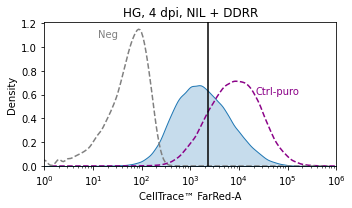

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))

# Threshold for iMNs
rep = 1
CTFR_low_thresh = CTFR_low_thresh_list[rep-1]

# Plot eGFP-A
x = 'CellTrace™ FarRed-A'
sns.kdeplot(data=data_4dpi.loc[
    (data_4dpi['cond.DDRR_cat'] == 'NIL.DDRR') & (data_4dpi['rep'] == rep)],
    ax=ax, x=x,
    common_norm=False, log_scale=(True, False),
    fill=True)

# Plot CTFR control
sns.kdeplot(data=data_4dpi[(data_4dpi['cond'] == 'Ctrl-puro')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='#8b0288', fill=False, linestyle='--')
ax.annotate('Ctrl-puro', (0.8, 0.5), color='#8b0288' , xycoords='axes fraction', ha='center')

# Plot neg ctrl
sns.kdeplot(data=data_4dpi[(data_4dpi['cond'] == 'Ctrl-neg')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.22, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(CTFR_low_thresh, 0, 1, color='black')

# Title
plt.title('HG, 4 dpi, NIL + DDRR')
# Adjust limits
CTFR_lim = (1, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(CTFR_lim)


/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/seaborn/utils.py:413: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


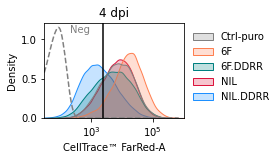

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(2.5,1.75))

# Threshold for hyperP
rep = 1
CTFR_low_thresh = CTFR_low_thresh_list[rep-1]

# Plot CTFR
x = 'CellTrace™ FarRed-A'
cond_DDRR_list = [
    'Ctrl-puro', '6F', '6F.DDRR', 'NIL', 'NIL.DDRR']
palette = {
    'Ctrl-puro': 'grey', '6F': 'coral', '6F.DDRR': 'teal',
    'NIL': 'crimson', 'NIL.DDRR': 'dodgerblue'
}

sns.kdeplot(data=data_4dpi.loc[(data_4dpi['rep'] == rep)],
    ax=ax, x=x, hue='cond.DDRR_cat', hue_order=cond_DDRR_list,
    common_norm=False, log_scale=(True, False),
    fill=True, palette=palette)

# Plot neg ctrl
sns.kdeplot(data=data_4dpi[(data_4dpi['cond'] == 'Ctrl-neg')], x=x, common_norm=False,
            ax=ax, log_scale=(True, False), color='grey', fill=False, linestyle='--')
ax.annotate('Neg', (0.26, 0.9), color='grey', xycoords='axes fraction', ha='center')

# Plot threshold
ax.axvline(CTFR_low_thresh, 0, 1, color='black')

# Adjust the legend
lmap = {
    'Ctrl-puro': 'Ctrl-puro', '6F': '6F', '6F.DDRR': '6F\n+DDRR',
    'NIL': 'NIL', 'NIL.DDRR': 'NIL\n+DDRR'
}
h,l = ax.get_legend_handles_labels()
sns.move_legend(ax,
    handles=h, labels=[lmap[i] for i in l[:]],
    title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)

# Title
plt.title('4 dpi')
# Adjust limits
# ax.set_ylim((0, 1))
CTFR_lim = (30, 1*10**6)
for sub_ax in plt.gcf().get_axes():
    sub_ax.set_xlim(CTFR_lim)

# plt.savefig(figpath + '4dpi_CTFR_dist_small.svg', bbox_inches='tight')

## Look at HyperP at 4 dpi

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL vs. NIL.DDRR: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:4.468e-05 Stat=-1.123e+01
6F vs. 6F.DDRR: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:3.965e-04 Stat=-7.630e+00
6F.DDRR vs. NIL.DDRR: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:2.544e-04 Stat=-8.266e+00
p-value annotation legend:
    

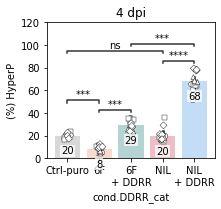

In [9]:
# General plotting params
x = 'cond.DDRR_cat'
y = 'percent'
cond_DDRR_list = [
    'Ctrl-puro', '6F', '6F.DDRR', 'NIL', 'NIL.DDRR']

palette = {
    'Ctrl-puro': 'grey', '6F': 'coral', '6F.DDRR': 'teal',
    'NIL': 'crimson', 'NIL.DDRR': 'dodgerblue'
}


marker_list = ['o', 's', '^', 'D']
units = 'well'

fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))

# Plot hyperP percent of all cells
sns.barplot(ax=ax, data=CTFR_hyperP_percent_4dpi_reps,
            x=x, y=y, order=cond_DDRR_list, units=units,
            alpha=0.3, palette=palette)
for (i, rep) in enumerate(CTFR_hyperP_percent_4dpi_reps.rep.unique()):
    sns.stripplot(ax=ax, data=CTFR_hyperP_percent_4dpi_reps[CTFR_hyperP_percent_4dpi_reps.rep == rep],
                x=x, y=y, order=cond_DDRR_list,
                dodge=True, marker=marker_list[i],
                color='white', size=5,
                edgecolor='black', linewidth=0.4,)

# Add in stats
pairs = [
    ('NIL', 'NIL.DDRR'),
    ('6F', '6F.DDRR'),
    ('NIL.DDRR', '6F.DDRR')
]
annot = Annotator(ax=ax, data=CTFR_hyperP_percent_4dpi, x=x, y=y,
                  pairs=pairs, order=cond_DDRR_list)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

pairs = [    
    ('Ctrl-puro', '6F'),
    ('Ctrl-puro', 'NIL'),
]
annot = Annotator(ax=ax, data=CTFR_hyperP_percent_4dpi, x=x, y=y,
                  pairs=pairs, order=cond_DDRR_list)
annot.configure(test=ttest_ind_greater, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=-20)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Format
# fig.tight_layout()  # Helps improve white spacing
ax.set_title('4 dpi')
ax.yaxis.set_label_text('(%) HyperP')
ax.set_xticklabels(['Ctrl-puro', '6F', '6F\n+ DDRR', 'NIL', 'NIL\n+ DDRR'])
ax.set_yticks(np.arange(0, 130, 20))

# plt.savefig(figpath + 'SI/4dpi_hyperP_percent_label.svg', bbox_inches='tight')

/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/natwang/Documents/GitHub/article-prolif-TF-levels/env/lib/python3.9/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NIL vs. NIL.DDRR: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:1.669e-03 Stat=-5.838e+00
6F vs. 6F.DDRR: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:3.503e-02 Stat=-3.021e+00
6F.DDRR vs. NIL.DDRR: t-test for independent samples from scipy with less 1-way (mean of the distribution underlying the first sample is less than the mean of the distribution underlying the second sample) with Bonferroni correction, P_val:2.685e-03 Stat=-5.323e+00
p-value annotation legend:
    

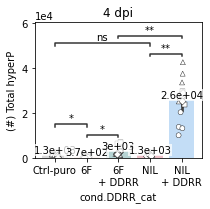

In [10]:
# General plotting params
x = 'cond.DDRR_cat'
y = 'count'
cond_DDRR_list = [
    'Ctrl-puro', '6F', '6F.DDRR', 'NIL', 'NIL.DDRR']

palette = {
    'Ctrl-puro': 'grey', '6F': 'coral', '6F.DDRR': 'teal',
    'NIL': 'crimson', 'NIL.DDRR': 'dodgerblue'
}

marker_list = ['o', 's', '^', 'D']
units = 'well'

fig, ax = plt.subplots(1, 1, figsize=(3, 2.5))

# Plot hyperP yield
sns.barplot(ax=ax, data=CTFR_hyperP_count_4dpi_reps,
            x=x, y=y, order=cond_DDRR_list, units=units,
            alpha=0.3, palette=palette)
for (i, rep) in enumerate(CTFR_hyperP_count_4dpi_reps.rep.unique()):
    sns.stripplot(ax=ax, data=CTFR_hyperP_count_4dpi_reps[CTFR_hyperP_count_4dpi_reps.rep == rep],
                x=x, y=y, order=cond_DDRR_list,
                dodge=True, marker=marker_list[i],
                color='white', size=5,
                edgecolor='black', linewidth=0.4,)

# Add in stats
pairs = [
    ('NIL', 'NIL.DDRR'),
    ('6F', '6F.DDRR'),
    ('NIL.DDRR', '6F.DDRR')
]
annot = Annotator(ax=ax, data=CTFR_hyperP_count_4dpi, x=x, y=y,
                  pairs=pairs, order=cond_DDRR_list)
annot.configure(test=ttest_ind_less, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

pairs = [    
    ('Ctrl-puro', '6F'),
    ('Ctrl-puro', 'NIL'),
]
annot = Annotator(ax=ax, data=CTFR_hyperP_count_4dpi, x=x, y=y,
                  pairs=pairs, order=cond_DDRR_list)
annot.configure(test=ttest_ind_greater, comparisons_correction='Bonferroni', text_format='star', loc='inside', verbose=2)
annot.apply_and_annotate()

# Add barplot labels
for sub_ax in plt.gcf().get_axes():
    for i in sub_ax.containers:
        bar_labels = sub_ax.bar_label(i, fmt='%0.2g', padding=0)
        # bar_labels = sub_ax.bar_label(i, fmt='%0.0f', padding=0)
        for label in bar_labels:
            label.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0, pad=1))    

# Format
# fig.tight_layout()  # Helps improve white spacing
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.set_xticklabels(['Ctrl-puro', '6F', '6F\n+ DDRR', 'NIL', 'NIL\n+ DDRR'])
ax.set_title('4 dpi')
ax.yaxis.set_label_text('(#) Total hyperP')

# plt.savefig(figpath + 'SI/4dpi_hyperP_count_label.svg', bbox_inches='tight')

# Plot hyperP yield vs. hyperP percent

In [12]:
# Integrate hyperP % and hyperP yield % at 4 dpi into single df
# CTFR_hyperP_percent_4dpi_reps
percent_4dpi_reps = CTFR_hyperP_percent_4dpi_reps.rename(columns={"percent":"hyperP_percent"}, copy=True)
percent_4dpi_reps.loc[:,'hyperP_count'] = 0
for index, row in percent_4dpi_reps.iterrows():

    hyperP_count = CTFR_hyperP_count_4dpi_reps.loc[
        (CTFR_hyperP_count_4dpi_reps['rep']==row.rep) &
        (CTFR_hyperP_count_4dpi_reps['well']==row.well) &
        (CTFR_hyperP_count_4dpi_reps['cond.DDRR_cat']==row['cond.DDRR_cat'])
        ]['count']
    percent_4dpi_reps.loc[index, 'hyperP_count'] = float(hyperP_count)

# Delete ctrl data
cond_list = ['Ctrl-puro', '6F', 'NIL',
             '6F.DDRR', 'NIL.DDRR']
percent_4dpi_reps = percent_4dpi_reps[ percent_4dpi_reps['cond.DDRR_cat'].isin(cond_list) ]

# Calc mean and SEM for each cond
grouping = ['cond.DDRR_cat', 'rep']
percent_4dpi_mean = percent_4dpi_reps.groupby(grouping).mean().reset_index()
percent_4dpi_SEM = percent_4dpi_reps.groupby(grouping).sem().reset_index()

In [13]:
xdata = percent_4dpi_mean['hyperP_percent']
ydata = percent_4dpi_mean['hyperP_count']

# # If positive
# def model(x, y_init, k):
#     return y_init*np.exp((k*x))
# popt, pcov = curve_fit(
#     model, xdata=xdata, ydata=ydata,
#     p0=[1, .05], bounds=([0, 0], [100, 1]))

# display(popt)

# If negative
def model(x, y_init, k, C):
    return y_init*np.exp((k*x)) + C
popt, pcov = curve_fit(
    model, xdata=xdata, ydata=ydata,
    p0=[1, .05, 0], bounds=([0, 0, -10**5], [10**5, 1**2, 10**5]))

display(popt)

y_pred = model(xdata, *popt)
y_avg = np.mean(ydata)
SSres = np.sum((ydata-y_pred)**2)
SStot = np.sum((ydata-y_avg)**2)
Rsq = 1 - SSres/SStot

print(Rsq)

array([ 8.72066543e+03,  2.09962299e-02, -1.15542351e+04])

0.9126245930223926


In [14]:
nboot = 10**4
# params_all = np.zeros((nboot, len(popt)))
# x_all = np.zeros((nboot, len(xdata)))
# y_all = np.zeros((nboot, len(xdata)))
params_all = np.zeros((len(popt), nboot))
x_all = np.zeros((len(xdata), nboot))
y_all = np.zeros((len(xdata), nboot))

########## ACTUAL ##########
x_CI = np.linspace(0, 100)
y_CI_all = np.zeros((len(x_CI), nboot))
############################

for i in np.arange(nboot):

    # Sample with replacement and fit
    data =  percent_4dpi_mean.sample(n=len(xdata), replace=True)
    x = 'hyperP_percent'
    y = 'hyperP_count'
    
    try:
        popt_i, pcov_i = curve_fit(
        model, xdata=data[x], ydata=data[y],
        p0=[10**3, .05, -10**3], bounds=([0, 0, -10**5], [10**6, 1**2, 10**5]))
    except RuntimeError:
       print("Couldn't solve, increasing max number of function evals")
       popt_i, pcov_i = curve_fit(
        model, xdata=data[x], ydata=data[y],
        p0=[10**3, .05, -10**3], bounds=([0, 0, -10**5], [10**6, 1**2, 10**5]), maxfev=5000)
    
    # # Store data
    # params_all[i, :] = popt_i
    # x_all[i, :] = data[x]
    # y_all[i, :] = model(data[x], *popt_i)
    params_all[:, i] = popt_i
    x_all[:, i] = data[x]
    y_all[:, i] = model(data[x], *popt_i)
    ########## ACTUAL ##########
    y_CI_all[:, i] = model(x_CI, *popt_i)
    ########## ACTUAL ##########


# Extract parameters and values
y_init = params_all[0::3].flatten()
k = params_all[1::3].flatten()
C = params_all[2::3].flatten()

x_all = np.reshape(x_all, (x_all.size, 1))
y_all = np.reshape(y_all, (y_all.size, 1))
# Convert (x, y) data to df
bootstrap_all = pd.DataFrame(np.hstack((x_all, y_all)), columns=['x', 'y'])

In [16]:
# Make 95% CI
CI = 95
# do it
y_lb = np.zeros(len(x_CI))
y_ub = np.zeros(len(x_CI))
for (i, x_curr) in enumerate(x_CI):
    y_curr =  y_CI_all[i]
    y_lb[i] = np.percentile(y_curr, (100-CI)/2)
    y_ub[i] = np.percentile(y_curr, 100-(100-CI)/2)


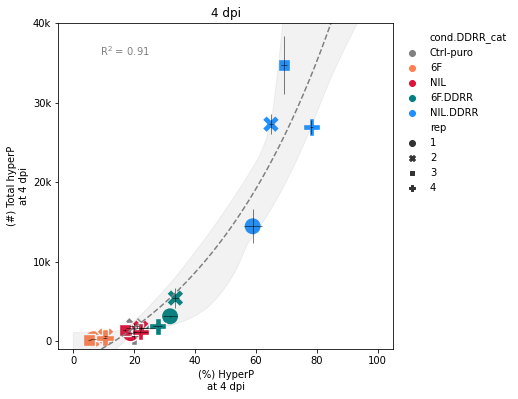

In [18]:
# Plotting params
x = 'hyperP_percent'
y = 'hyperP_count'
style = 'rep'
hue = 'cond.DDRR_cat'
hue_order = ['Ctrl-puro', '6F', 'NIL',
             '6F.DDRR', 'NIL.DDRR']
palette = {
    'Ctrl-puro': 'grey', '6F': 'coral', '6F.DDRR': 'teal',
    'NIL': 'crimson', 'NIL.DDRR': 'dodgerblue'
}

# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.errorbar(x=percent_4dpi_mean[x], y=percent_4dpi_mean[y],
            xerr=percent_4dpi_SEM[x], yerr=percent_4dpi_SEM[y],
            color='None', ecolor='black', elinewidth=0.5)
            
f = sns.scatterplot(ax=ax,
    data=percent_4dpi_mean,
    x=x, y=y, hue=hue, hue_order=hue_order,
    style=style,
    s=300, palette=palette)

# Plot model fit
x_line = np.linspace(0, 100, 10**4)
y_line = model(x_line, *popt)
plt.plot(x_line, y_line, c='grey', ls='--')
ax.fill_between(x_CI, y_lb, y_ub, color='grey', alpha=0.1) # CI
plt.annotate('R$^2$ = {:.2f}'.format(Rsq), (0.2, 0.9), color='grey', xycoords='axes fraction', ha='center')


sns.move_legend(ax, title='', loc='upper left', bbox_to_anchor=(1,1), frameon=False)
ax.set_xticks(np.arange(0, 110, 20))
ax.set_yticks(np.arange(0, 4*10**4+1, 10**4))
ax.set_ylim((-10**3, 4*10**4))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax.xaxis.set_label_text('(%) HyperP\nat 4 dpi')
ax.yaxis.set_label_text('(#) Total hyperP\nat 4 dpi')
plt.title('4 dpi')
k_formatter = FuncFormatter(lambda x, _: f'{x:.0f}' if abs(x) < 1000 else f'{x/1000:.0f}k')
ax.yaxis.set_major_formatter(k_formatter)
# plt.savefig(figpath + '4dpi_hyperP_countvpercent_large.svg', bbox_inches='tight')